In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 4

In [3]:

#Load dataset
def load_dataset(path=r'dataset_test_v3.csv'):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [5]:
def prepare_data(df):
  # df_aux = df.drop(columns=['nr_ruas_afetadas', 'comprimento_fila_metros', 'demora_fila_segundos'], inplace=False)
  df_aux = df
  df_aux["data"] = pd.to_datetime(df_aux["data"])
  df_aux = df_aux.sort_values('data')
  df_aux = df_aux.set_index('data')
  return df_aux

In [6]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    df[['nr_ruas_afetadas']] = scaler.fit_transform(df[['nr_ruas_afetadas']])
    df[['comprimento_fila_metros']] = scaler.fit_transform(df[['comprimento_fila_metros']])
    df[['demora_fila_segundos']] = scaler.fit_transform(df[['demora_fila_segundos']])
    df[['Nr_acidentes']] = scaler.fit_transform(df[['Nr_acidentes']])

    return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  # plt.plot(epochs_range,mae,label='Training MAE')
  # plt.plot(epochs_range,val_mae,label='Validation MAE')
  # plt.plot(epochs_range,rmse,label='Training RMSE')
  # plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [8]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [9]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
# 1 LSTM, 2 Densas
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features)))
    #

    model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
    model.add(tf.keras.layers.Dense(n_variate, activation='linear'))

    #model summary (and save it as PNG)
    tf.keras.utils.plot_model(model, 'accidents_model.png', show_shapes=True)
    model.summary()
    return model

In [12]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [13]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    list_yhat = [yhat[0][i] for i in range(len(yhat[0]))]
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[list_yhat],axis=0) #adiciona previsão recente ao input
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(14,6))
  plt.plot(range(len(data)), data['Nr_acidentes'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Nr de Acidentes em Braga')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
'''tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 4 },
                2: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 4 },
                3: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 4 },

                #
                4: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 2 },
                5: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                6: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 }#,
                #
                #7: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits': 5, 'epochs' : 10,  'batch_size' : 1 },
                #8: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 50,  'batch_size' : 1 },
                #9: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 100,  'batch_size' : 1 }

                }'''

tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}

# record da history de cada modelo
record = {}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17664     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 22,084
Trainable params: 22,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 3s 61ms/step - loss: 0.2871 - mae: 0.2421 - rmse: 0.2872 - val_loss: 0.4669 - val_mae: 0.4206 - val_rmse: 0.4475
Epoch 2/10
16/16 [==============================] - 0s 8ms/step - loss: 0.2957 - mae: 0.2439 - rmse: 0.2958 - val_loss: 0.4914 - val_mae: 0.4470 - val_rmse: 0.4717
Epoch 3/10
16/16 [==============================] - 0

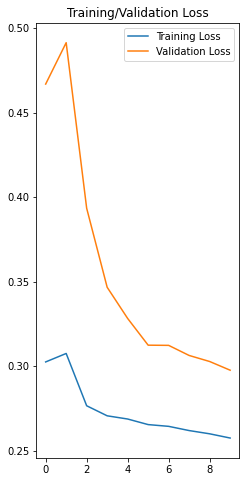

Epoch 1/10
31/31 [==============================] - 1s 8ms/step - loss: 0.2985 - mae: 0.2562 - rmse: 0.2985 - val_loss: 0.2274 - val_mae: 0.1999 - val_rmse: 0.2342
Epoch 2/10
31/31 [==============================] - 0s 6ms/step - loss: 0.3005 - mae: 0.2571 - rmse: 0.3005 - val_loss: 0.2181 - val_mae: 0.1828 - val_rmse: 0.2195
Epoch 3/10
31/31 [==============================] - 0s 6ms/step - loss: 0.2990 - mae: 0.2543 - rmse: 0.2990 - val_loss: 0.2303 - val_mae: 0.2057 - val_rmse: 0.2340
Epoch 4/10
31/31 [==============================] - 0s 6ms/step - loss: 0.2775 - mae: 0.2338 - rmse: 0.2775 - val_loss: 0.2096 - val_mae: 0.1796 - val_rmse: 0.2097
Epoch 5/10
31/31 [==============================] - 0s 6ms/step - loss: 0.2802 - mae: 0.2342 - rmse: 0.2802 - val_loss: 0.2020 - val_mae: 0.1642 - val_rmse: 0.2002

Epoch 00005: val_loss improved from 0.29761 to 0.20201, saving model to my_model_5_0.202.h5
Epoch 6/10
31/31 [==============================] - 0s 5ms/step - loss: 0.2872 - mae: 0

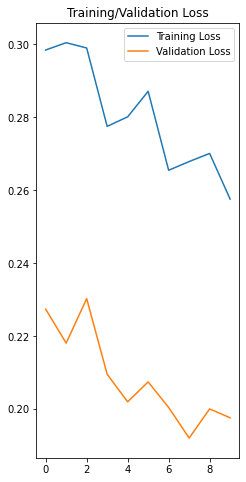

Epoch 1/10
47/47 [==============================] - 1s 16ms/step - loss: 0.2593 - mae: 0.2131 - rmse: 0.2637 - val_loss: 0.4093 - val_mae: 0.3371 - val_rmse: 0.4093
Epoch 2/10
47/47 [==============================] - 0s 6ms/step - loss: 0.2656 - mae: 0.2197 - rmse: 0.2691 - val_loss: 0.3932 - val_mae: 0.3243 - val_rmse: 0.3932
Epoch 3/10
47/47 [==============================] - 0s 6ms/step - loss: 0.2508 - mae: 0.2064 - rmse: 0.2535 - val_loss: 0.3612 - val_mae: 0.3005 - val_rmse: 0.3612
Epoch 4/10
47/47 [==============================] - 0s 5ms/step - loss: 0.2461 - mae: 0.2023 - rmse: 0.2488 - val_loss: 0.3442 - val_mae: 0.2900 - val_rmse: 0.3442
Epoch 5/10
47/47 [==============================] - 0s 6ms/step - loss: 0.2422 - mae: 0.2009 - rmse: 0.2447 - val_loss: 0.3410 - val_mae: 0.2882 - val_rmse: 0.3410

Epoch 00005: val_loss did not improve from 0.19763
Epoch 6/10
47/47 [==============================] - 0s 6ms/step - loss: 0.2413 - mae: 0.2005 - rmse: 0.2437 - val_loss: 0.3428 

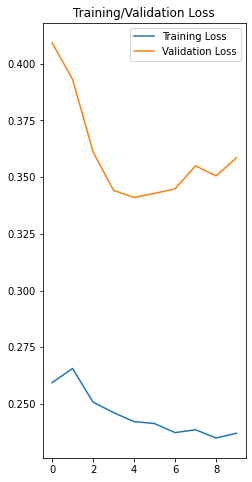

[array([[150.65962, 140.2153 , 109.91598, 147.00804]], dtype=float32), array([[298.28537, 293.55292, 270.66016, 311.5676 ]], dtype=float32), array([[343.74612, 339.10013, 315.84833, 353.75955]], dtype=float32), array([[316.60474, 314.14697, 296.59073, 329.34906]], dtype=float32), array([[341.5972 , 341.2932 , 329.74725, 355.24268]], dtype=float32), array([[366.52676, 367.41312, 358.622  , 379.66016]], dtype=float32), array([[265.74738, 268.1691 , 277.9925 , 270.2155 ]], dtype=float32), array([[223.15552, 223.87091, 251.66899, 225.5959 ]], dtype=float32), array([[282.3848 , 283.61163, 302.9252 , 290.94476]], dtype=float32), array([[309.45804, 310.3795 , 323.2337 , 318.8644 ]], dtype=float32), array([[328.90778, 329.2988 , 337.32492, 338.42493]], dtype=float32), array([[353.24188, 353.02365, 356.1466 , 362.2701 ]], dtype=float32), array([[357.93274, 357.44724, 360.04642, 367.4433 ]], dtype=float32), array([[306.52808, 304.6675 , 321.83728, 311.4055 ]], dtype=float32), array([[268.44275, 

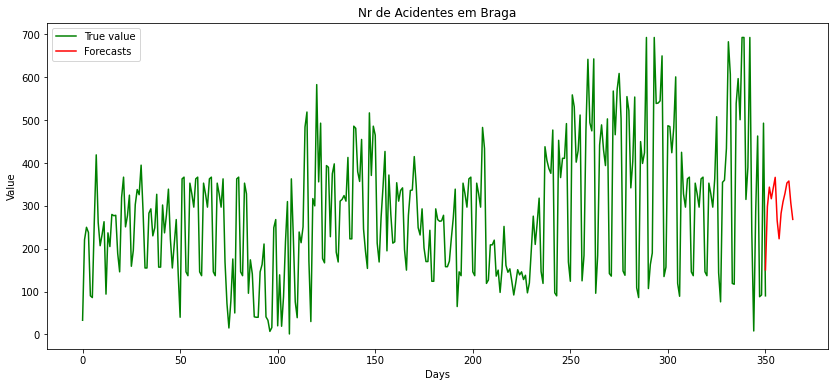

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 22,084
Trainable params: 22,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 2s 39ms/step - loss: 0.3195 - mae: 0.2705 - rmse: 0.3195 - val_loss: 0.5026 - val_mae: 0.4605 - val_rmse: 0.4840
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.2806 - mae: 0.2293 - rmse: 0.2808 - val_loss: 0.4993 - val_mae: 0.4585 - val_rmse: 0.4798
Epoch 3/50
16/16 [==============================] -

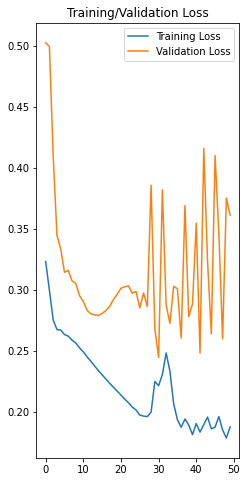

Epoch 1/50
31/31 [==============================] - 1s 8ms/step - loss: 0.2788 - mae: 0.2348 - rmse: 0.2788 - val_loss: 0.2267 - val_mae: 0.1834 - val_rmse: 0.2456
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.2827 - mae: 0.2338 - rmse: 0.2827 - val_loss: 0.2292 - val_mae: 0.1927 - val_rmse: 0.2399
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.2618 - mae: 0.2191 - rmse: 0.2618 - val_loss: 0.2269 - val_mae: 0.1898 - val_rmse: 0.2444
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.2646 - mae: 0.2199 - rmse: 0.2646 - val_loss: 0.2253 - val_mae: 0.1908 - val_rmse: 0.2317
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.2540 - mae: 0.2076 - rmse: 0.2540 - val_loss: 0.2301 - val_mae: 0.1978 - val_rmse: 0.2443

Epoch 00005: val_loss improved from 0.26390 to 0.23009, saving model to my_model_5_0.230.h5
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.2490 - mae: 0

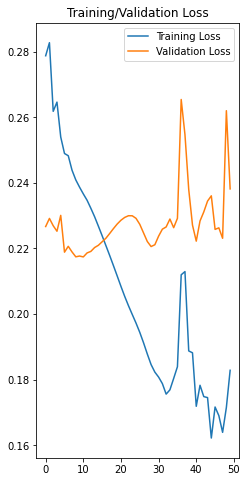

Epoch 1/50
47/47 [==============================] - 1s 17ms/step - loss: 0.2217 - mae: 0.1849 - rmse: 0.2268 - val_loss: 0.5345 - val_mae: 0.4541 - val_rmse: 0.5345
Epoch 2/50
47/47 [==============================] - 0s 6ms/step - loss: 0.2000 - mae: 0.1647 - rmse: 0.2035 - val_loss: 0.3442 - val_mae: 0.3056 - val_rmse: 0.3442
Epoch 3/50
47/47 [==============================] - 0s 6ms/step - loss: 0.1972 - mae: 0.1605 - rmse: 0.2016 - val_loss: 0.3335 - val_mae: 0.2733 - val_rmse: 0.3335
Epoch 4/50
47/47 [==============================] - 0s 6ms/step - loss: 0.1918 - mae: 0.1590 - rmse: 0.1952 - val_loss: 0.3277 - val_mae: 0.2804 - val_rmse: 0.3277
Epoch 5/50
47/47 [==============================] - 0s 6ms/step - loss: 0.1878 - mae: 0.1536 - rmse: 0.1918 - val_loss: 0.3697 - val_mae: 0.3014 - val_rmse: 0.3697

Epoch 00005: val_loss did not improve from 0.21769
Epoch 6/50
47/47 [==============================] - 0s 6ms/step - loss: 0.1882 - mae: 0.1562 - rmse: 0.1907 - val_loss: 0.3806 

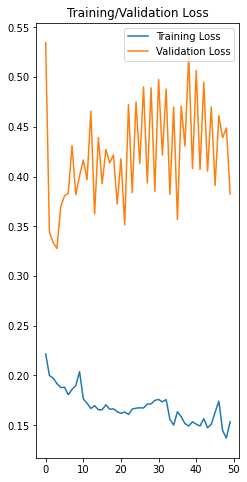

[array([[84.52865 , 58.097267, 66.939674, 51.25657 ]], dtype=float32), array([[327.2445 , 310.09332, 306.47037, 293.0472 ]], dtype=float32), array([[358.31378, 331.64197, 333.8403 , 329.82498]], dtype=float32), array([[177.00757, 157.30276, 168.40984, 150.46432]], dtype=float32), array([[219.9312 , 206.66507, 204.76414, 197.57132]], dtype=float32), array([[340.70844, 317.42932, 325.45422, 316.73083]], dtype=float32), array([[259.53632, 247.16745, 260.1134 , 245.54666]], dtype=float32), array([[181.67705, 173.59178, 176.50847, 173.70703]], dtype=float32), array([[325.885  , 318.8755 , 316.73642, 320.90457]], dtype=float32), array([[320.99786, 311.27972, 316.31598, 316.55215]], dtype=float32), array([[199.67026, 193.05534, 196.74661, 193.67604]], dtype=float32), array([[235.13986, 230.58308, 227.0713 , 232.02625]], dtype=float32), array([[322.8538 , 316.639  , 315.09073, 321.82724]], dtype=float32), array([[264.15512, 258.29407, 259.70508, 260.97238]], dtype=float32), array([[235.38431, 

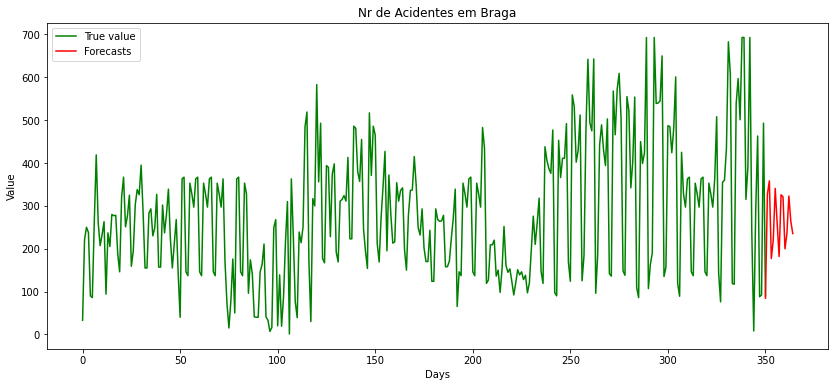

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 22,084
Trainable params: 22,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 2s 42ms/step - loss: 0.2867 - mae: 0.2448 - rmse: 0.2868 - val_loss: 0.4929 - val_mae: 0.4500 - val_rmse: 0.4743
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.2893 - mae: 0.2385 - rmse: 0.2894 - val_loss: 0.4842 - val_mae: 0.4435 - val_rmse: 0.4644
Epoch 3/100
16/16 [==============================

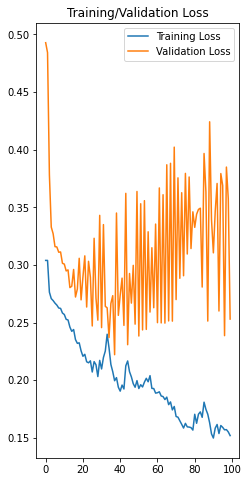

Epoch 1/100
31/31 [==============================] - 1s 8ms/step - loss: 0.2972 - mae: 0.2492 - rmse: 0.2972 - val_loss: 0.2580 - val_mae: 0.2214 - val_rmse: 0.2615
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2753 - mae: 0.2322 - rmse: 0.2753 - val_loss: 0.2431 - val_mae: 0.2029 - val_rmse: 0.2565
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2439 - mae: 0.2012 - rmse: 0.2439 - val_loss: 0.2504 - val_mae: 0.2079 - val_rmse: 0.2733
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2397 - mae: 0.1987 - rmse: 0.2397 - val_loss: 0.2548 - val_mae: 0.2124 - val_rmse: 0.2707
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.2385 - mae: 0.1955 - rmse: 0.2385 - val_loss: 0.2534 - val_mae: 0.2112 - val_rmse: 0.2672

Epoch 00005: val_loss did not improve from 0.23075
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 0.2301 - mae: 0.1884 - rmse: 0.2301 - val_loss: 0.

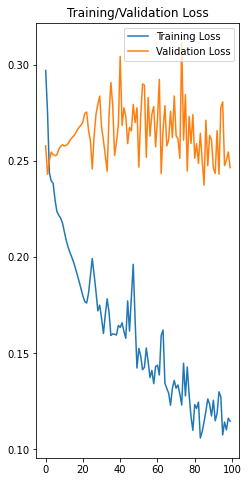

Epoch 1/100
47/47 [==============================] - 1s 17ms/step - loss: 0.1648 - mae: 0.1364 - rmse: 0.1695 - val_loss: 0.6239 - val_mae: 0.5454 - val_rmse: 0.6239
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 0.1853 - mae: 0.1564 - rmse: 0.1883 - val_loss: 0.4294 - val_mae: 0.3510 - val_rmse: 0.4294
Epoch 3/100
47/47 [==============================] - 0s 7ms/step - loss: 0.1714 - mae: 0.1397 - rmse: 0.1746 - val_loss: 0.5462 - val_mae: 0.4425 - val_rmse: 0.5462
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: 0.1504 - mae: 0.1246 - rmse: 0.1535 - val_loss: 0.6159 - val_mae: 0.5208 - val_rmse: 0.6159
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: 0.1508 - mae: 0.1241 - rmse: 0.1537 - val_loss: 0.4999 - val_mae: 0.4176 - val_rmse: 0.4999

Epoch 00005: val_loss did not improve from 0.23075
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: 0.1417 - mae: 0.1163 - rmse: 0.1448 - val_loss: 0

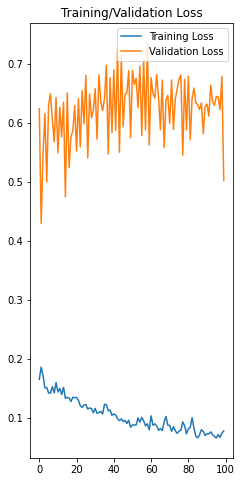

[array([[116.54646, 117.316  , 113.57179, 117.33607]], dtype=float32), array([[346.04364, 343.0528 , 351.57288, 346.04056]], dtype=float32), array([[273.45892, 274.6232 , 278.2018 , 272.8152 ]], dtype=float32), array([[196.56282, 193.19882, 184.65405, 191.40244]], dtype=float32), array([[280.1062 , 276.62924, 273.69537, 277.36612]], dtype=float32), array([[261.04865, 262.5508 , 259.54688, 257.96088]], dtype=float32), array([[258.91757, 256.62204, 246.16762, 249.95117]], dtype=float32), array([[262.1704 , 259.02014, 252.87674, 247.54243]], dtype=float32), array([[344.1521 , 347.52563, 338.9281 , 340.611  ]], dtype=float32), array([[266.41885, 267.68967, 256.91016, 251.70668]], dtype=float32), array([[214.79672, 214.21486, 206.11285, 200.52689]], dtype=float32), array([[300.34305, 297.7049 , 291.92706, 286.52213]], dtype=float32), array([[252.02905, 253.00246, 245.73975, 239.82918]], dtype=float32), array([[222.55864, 224.27988, 216.21916, 212.31886]], dtype=float32), array([[336.83017, 

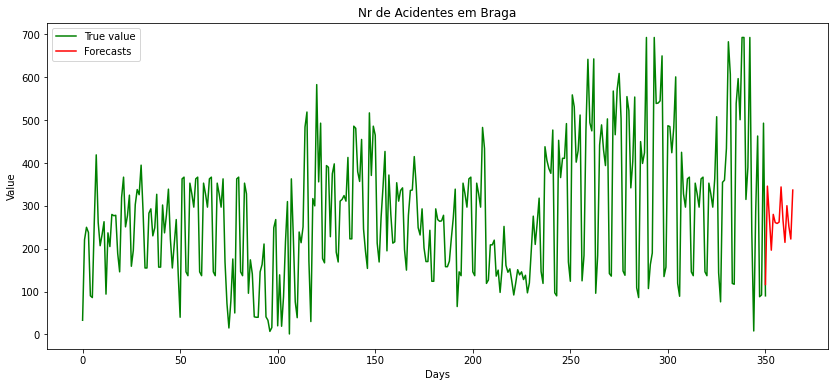

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 22,084
Trainable params: 22,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
16/16 [==============================] - 2s 42ms/step - loss: 0.2888 - mae: 0.2530 - rmse: 0.2889 - val_loss: 0.5773 - val_mae: 0.5447 - val_rmse: 0.5610
Epoch 2/60
16/16 [==============================] - 0s 11ms/step - loss: 0.2842 - mae: 0.2440 - rmse: 0.2844 - val_loss: 0.5538 - val_mae: 0.5180 - val_rmse: 0.5335
Epoch 3/60
16/16 [==============================] 

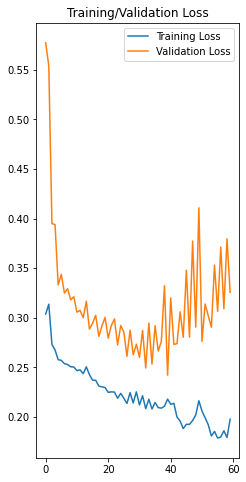

Epoch 1/60
31/31 [==============================] - 0s 10ms/step - loss: 0.3421 - mae: 0.2947 - rmse: 0.3408 - val_loss: 0.2908 - val_mae: 0.2483 - val_rmse: 0.3509
Epoch 2/60
31/31 [==============================] - 0s 8ms/step - loss: 0.2940 - mae: 0.2592 - rmse: 0.2935 - val_loss: 0.2801 - val_mae: 0.2437 - val_rmse: 0.3151
Epoch 3/60
31/31 [==============================] - 0s 8ms/step - loss: 0.2752 - mae: 0.2397 - rmse: 0.2742 - val_loss: 0.2450 - val_mae: 0.2072 - val_rmse: 0.2776
Epoch 4/60
31/31 [==============================] - 0s 8ms/step - loss: 0.2694 - mae: 0.2317 - rmse: 0.2687 - val_loss: 0.2660 - val_mae: 0.2352 - val_rmse: 0.2945
Epoch 5/60
31/31 [==============================] - 0s 8ms/step - loss: 0.2549 - mae: 0.2149 - rmse: 0.2540 - val_loss: 0.2510 - val_mae: 0.2155 - val_rmse: 0.2810

Epoch 00005: val_loss did not improve from 0.24203
Epoch 6/60
31/31 [==============================] - 0s 8ms/step - loss: 0.2629 - mae: 0.2242 - rmse: 0.2620 - val_loss: 0.2503 

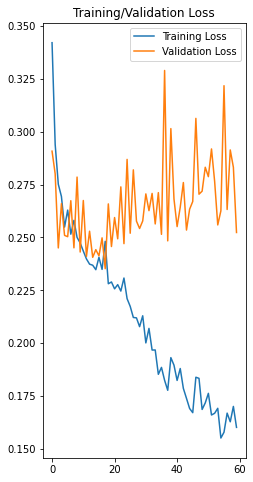

Epoch 1/60
47/47 [==============================] - 1s 18ms/step - loss: 0.1936 - mae: 0.1610 - rmse: 0.2016 - val_loss: 0.4765 - val_mae: 0.3831 - val_rmse: 0.4765
Epoch 2/60
47/47 [==============================] - 0s 7ms/step - loss: 0.2146 - mae: 0.1785 - rmse: 0.2196 - val_loss: 0.4201 - val_mae: 0.3464 - val_rmse: 0.4201
Epoch 3/60
47/47 [==============================] - 0s 8ms/step - loss: 0.2012 - mae: 0.1649 - rmse: 0.2065 - val_loss: 0.4686 - val_mae: 0.3816 - val_rmse: 0.4686
Epoch 4/60
47/47 [==============================] - 0s 9ms/step - loss: 0.1944 - mae: 0.1626 - rmse: 0.1970 - val_loss: 0.3988 - val_mae: 0.3225 - val_rmse: 0.3988
Epoch 5/60
47/47 [==============================] - 0s 8ms/step - loss: 0.1757 - mae: 0.1441 - rmse: 0.1776 - val_loss: 0.4294 - val_mae: 0.3450 - val_rmse: 0.4294

Epoch 00005: val_loss did not improve from 0.24203
Epoch 6/60
47/47 [==============================] - 0s 8ms/step - loss: 0.1771 - mae: 0.1491 - rmse: 0.1791 - val_loss: 0.4613 

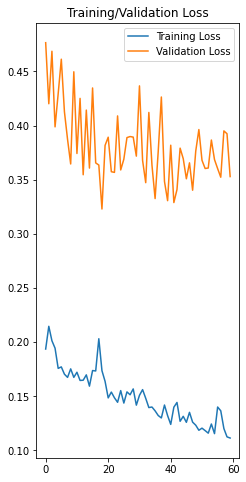

[array([[ 96.25063 , 110.99249 ,  86.639145,  94.08901 ]], dtype=float32), array([[212.38004, 227.499  , 209.82059, 211.21262]], dtype=float32), array([[284.06967, 292.49115, 283.17795, 286.51477]], dtype=float32), array([[254.73772, 267.77127, 249.10933, 255.30211]], dtype=float32), array([[242.6932 , 261.58813, 237.81271, 241.82669]], dtype=float32), array([[217.78258, 231.63593, 214.3956 , 217.61897]], dtype=float32), array([[158.8016 , 169.71788, 155.87265, 159.3744 ]], dtype=float32), array([[178.0003 , 190.58287, 182.15285, 181.58318]], dtype=float32), array([[237.96547, 254.76471, 239.66026, 241.69002]], dtype=float32), array([[257.9586 , 270.98355, 256.53717, 258.28647]], dtype=float32), array([[276.76324, 287.58005, 275.63242, 277.44574]], dtype=float32), array([[257.0124 , 269.57333, 254.3481 , 257.37415]], dtype=float32), array([[184.51843, 198.00883, 182.7059 , 185.74539]], dtype=float32), array([[193.51869, 206.57173, 194.34845, 195.24806]], dtype=float32), array([[235.106

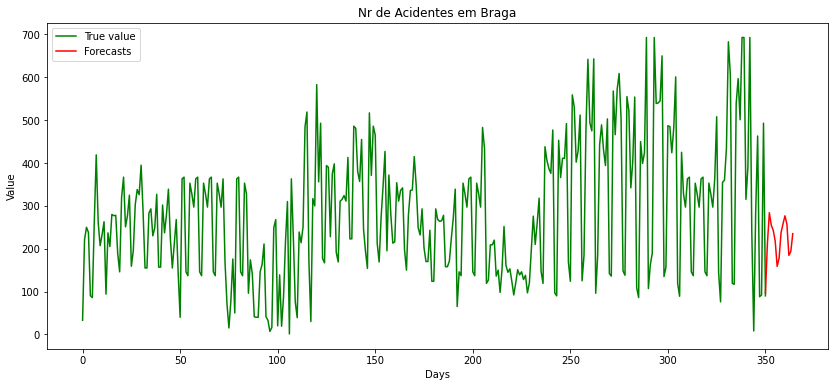

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 260       
Total params: 22,084
Trainable params: 22,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
16/16 [==============================] - 2s 42ms/step - loss: 0.3146 - mae: 0.2711 - rmse: 0.3147 - val_loss: 0.5659 - val_mae: 0.5320 - val_rmse: 0.5511
Epoch 2/90
16/16 [==============================] - 0s 9ms/step - loss: 0.3125 - mae: 0.2715 - rmse: 0.3126 - val_loss: 0.5869 - val_mae: 0.5553 - val_rmse: 0.5681
Epoch 3/90
16/16 [==============================] -

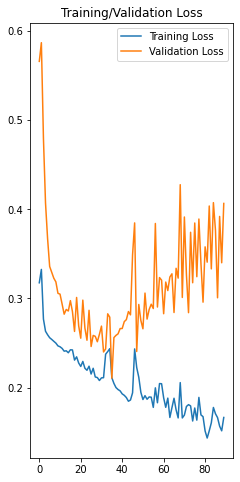

Epoch 1/90
31/31 [==============================] - 0s 10ms/step - loss: 0.2758 - mae: 0.2334 - rmse: 0.2758 - val_loss: 0.3166 - val_mae: 0.2798 - val_rmse: 0.3771
Epoch 2/90
31/31 [==============================] - 0s 7ms/step - loss: 0.2726 - mae: 0.2381 - rmse: 0.2719 - val_loss: 0.2620 - val_mae: 0.2230 - val_rmse: 0.3060
Epoch 3/90
31/31 [==============================] - 0s 8ms/step - loss: 0.2525 - mae: 0.2187 - rmse: 0.2519 - val_loss: 0.2765 - val_mae: 0.2421 - val_rmse: 0.3181
Epoch 4/90
31/31 [==============================] - 0s 8ms/step - loss: 0.2424 - mae: 0.2115 - rmse: 0.2418 - val_loss: 0.2707 - val_mae: 0.2375 - val_rmse: 0.3062
Epoch 5/90
31/31 [==============================] - 0s 8ms/step - loss: 0.2381 - mae: 0.2040 - rmse: 0.2378 - val_loss: 0.2719 - val_mae: 0.2392 - val_rmse: 0.3087

Epoch 00005: val_loss did not improve from 0.25977
Epoch 6/90
31/31 [==============================] - 0s 8ms/step - loss: 0.2301 - mae: 0.1976 - rmse: 0.2297 - val_loss: 0.2675 

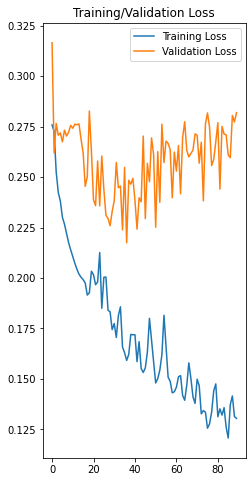

Epoch 1/90
47/47 [==============================] - 1s 18ms/step - loss: 0.1932 - mae: 0.1632 - rmse: 0.1981 - val_loss: 0.5277 - val_mae: 0.4828 - val_rmse: 0.5277
Epoch 2/90
47/47 [==============================] - 0s 7ms/step - loss: 0.1863 - mae: 0.1557 - rmse: 0.1883 - val_loss: 0.5596 - val_mae: 0.5060 - val_rmse: 0.5596
Epoch 3/90
47/47 [==============================] - 0s 7ms/step - loss: 0.1649 - mae: 0.1346 - rmse: 0.1661 - val_loss: 0.4666 - val_mae: 0.4065 - val_rmse: 0.4666
Epoch 4/90
47/47 [==============================] - 0s 7ms/step - loss: 0.1629 - mae: 0.1353 - rmse: 0.1641 - val_loss: 0.3503 - val_mae: 0.2742 - val_rmse: 0.3503
Epoch 5/90
47/47 [==============================] - 0s 7ms/step - loss: 0.1565 - mae: 0.1274 - rmse: 0.1557 - val_loss: 0.4580 - val_mae: 0.4040 - val_rmse: 0.4580

Epoch 00005: val_loss did not improve from 0.22384
Epoch 6/90
47/47 [==============================] - 0s 8ms/step - loss: 0.1570 - mae: 0.1300 - rmse: 0.1584 - val_loss: 0.4709 

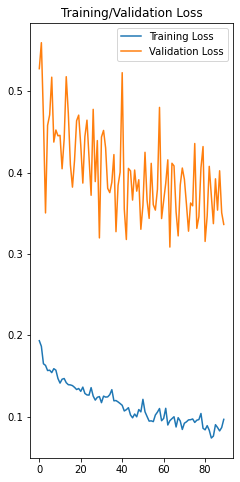

[array([[122.40537 , 117.61328 , 114.626526, 121.27721 ]], dtype=float32), array([[252.51569, 246.12529, 241.93657, 252.00658]], dtype=float32), array([[295.91696, 295.9044 , 300.64548, 295.44772]], dtype=float32), array([[245.25081, 245.70467, 248.84558, 246.32378]], dtype=float32), array([[247.77438, 249.3408 , 247.10786, 251.18831]], dtype=float32), array([[216.65193, 213.13538, 211.82013, 216.5278 ]], dtype=float32), array([[191.5272 , 189.97449, 191.29161, 189.11368]], dtype=float32), array([[266.7563 , 258.22696, 255.11293, 259.4615 ]], dtype=float32), array([[275.45706, 267.15826, 264.96274, 269.5944 ]], dtype=float32), array([[328.66464, 330.03705, 330.36496, 330.4715 ]], dtype=float32), array([[320.1468 , 325.12073, 323.27377, 325.582  ]], dtype=float32), array([[236.10478, 238.64287, 234.97849, 237.99677]], dtype=float32), array([[219.97353, 219.90775, 217.16035, 217.84332]], dtype=float32), array([[249.68768, 244.90749, 242.837  , 243.5114 ]], dtype=float32), array([[244.182

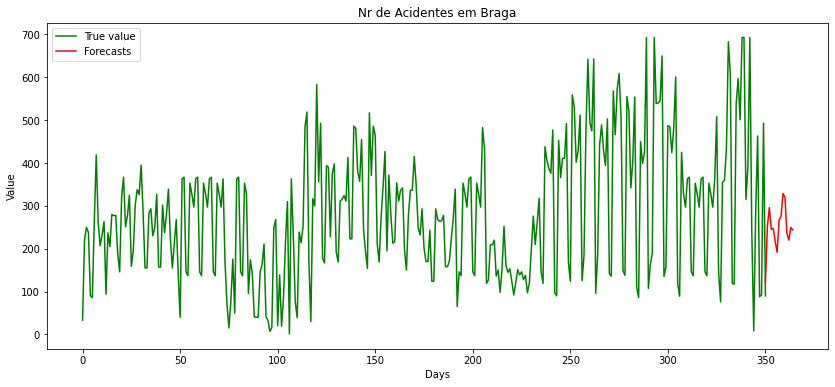

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 260       
Total params: 22,084
Trainable params: 22,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
16/16 [==============================] - 2s 42ms/step - loss: 0.2894 - mae: 0.2501 - rmse: 0.2895 - val_loss: 0.4634 - val_mae: 0.4136 - val_rmse: 0.4454
Epoch 2/120
16/16 [==============================] - 0s 9ms/step - loss: 0.2776 - mae: 0.2397 - rmse: 0.2778 - val_loss: 0.5138 - val_mae: 0.4638 - val_rmse: 0.4945
Epoch 3/120
16/16 [==============================

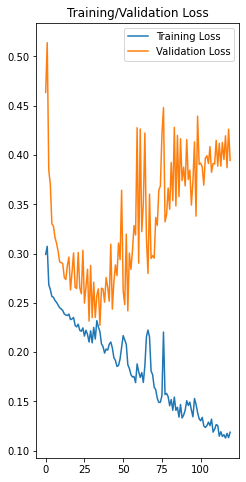

Epoch 1/120
31/31 [==============================] - 0s 12ms/step - loss: 0.2789 - mae: 0.2354 - rmse: 0.2793 - val_loss: 0.3421 - val_mae: 0.3084 - val_rmse: 0.4134
Epoch 2/120
31/31 [==============================] - 0s 8ms/step - loss: 0.2630 - mae: 0.2308 - rmse: 0.2625 - val_loss: 0.2623 - val_mae: 0.2332 - val_rmse: 0.3036
Epoch 3/120
31/31 [==============================] - 0s 8ms/step - loss: 0.2343 - mae: 0.2053 - rmse: 0.2339 - val_loss: 0.2716 - val_mae: 0.2416 - val_rmse: 0.3148
Epoch 4/120
31/31 [==============================] - 0s 9ms/step - loss: 0.2274 - mae: 0.1969 - rmse: 0.2271 - val_loss: 0.2773 - val_mae: 0.2510 - val_rmse: 0.3155
Epoch 5/120
31/31 [==============================] - 0s 9ms/step - loss: 0.2206 - mae: 0.1901 - rmse: 0.2204 - val_loss: 0.2810 - val_mae: 0.2582 - val_rmse: 0.3207

Epoch 00005: val_loss did not improve from 0.26418
Epoch 6/120
31/31 [==============================] - 0s 9ms/step - loss: 0.2113 - mae: 0.1802 - rmse: 0.2111 - val_loss: 0

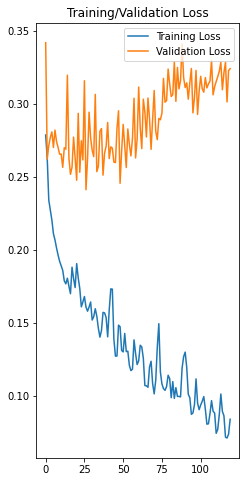

Epoch 1/120
47/47 [==============================] - 1s 18ms/step - loss: 0.1920 - mae: 0.1635 - rmse: 0.1943 - val_loss: 0.4779 - val_mae: 0.4054 - val_rmse: 0.4779
Epoch 2/120
47/47 [==============================] - 0s 8ms/step - loss: 0.1741 - mae: 0.1444 - rmse: 0.1755 - val_loss: 0.3828 - val_mae: 0.2947 - val_rmse: 0.3828
Epoch 3/120
47/47 [==============================] - 0s 8ms/step - loss: 0.1675 - mae: 0.1399 - rmse: 0.1668 - val_loss: 0.3959 - val_mae: 0.3217 - val_rmse: 0.3959
Epoch 4/120
47/47 [==============================] - 0s 8ms/step - loss: 0.1401 - mae: 0.1158 - rmse: 0.1406 - val_loss: 0.4467 - val_mae: 0.3828 - val_rmse: 0.4467
Epoch 5/120
47/47 [==============================] - 0s 8ms/step - loss: 0.1441 - mae: 0.1189 - rmse: 0.1419 - val_loss: 0.4134 - val_mae: 0.3443 - val_rmse: 0.4134

Epoch 00005: val_loss did not improve from 0.25745
Epoch 6/120
47/47 [==============================] - 0s 8ms/step - loss: 0.1367 - mae: 0.1107 - rmse: 0.1370 - val_loss: 0

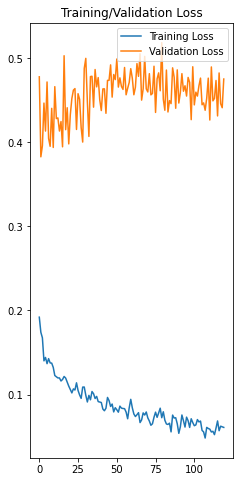

[array([[206.74184, 206.1933 , 202.94096, 208.65967]], dtype=float32), array([[351.9177 , 351.13535, 350.88208, 351.1745 ]], dtype=float32), array([[334.05673, 333.8733 , 331.72232, 334.99136]], dtype=float32), array([[228.17278, 228.80394, 226.12146, 233.2429 ]], dtype=float32), array([[193.35587, 191.4469 , 191.27773, 196.57686]], dtype=float32), array([[243.48198, 241.80067, 241.7126 , 246.98215]], dtype=float32), array([[200.79204, 200.3123 , 198.60167, 206.39021]], dtype=float32), array([[260.8951 , 261.53293, 257.05496, 266.3116 ]], dtype=float32), array([[345.12347, 345.6003 , 342.58487, 347.30194]], dtype=float32), array([[309.60297, 310.32355, 306.20572, 312.4315 ]], dtype=float32), array([[196.66876, 196.31415, 193.56903, 201.84956]], dtype=float32), array([[189.80858, 189.88766, 190.7491 , 193.38133]], dtype=float32), array([[245.90353, 246.54372, 247.5778 , 248.24068]], dtype=float32), array([[261.72424, 263.9213 , 262.42947, 265.59592]], dtype=float32), array([[272.71158, 

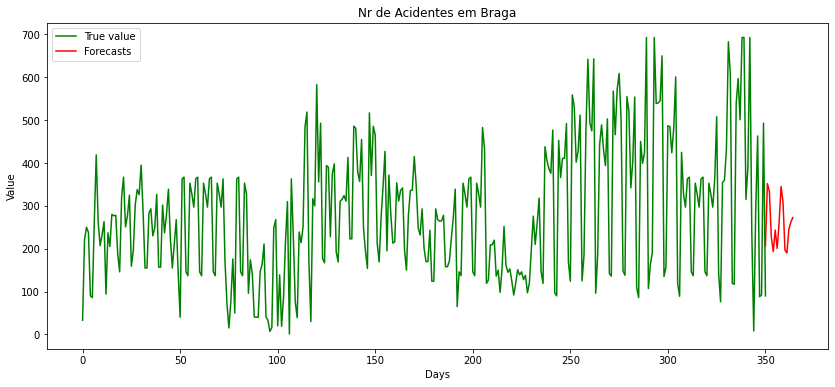

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 260       
Total params: 22,084
Trainable params: 22,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 2s 67ms/step - loss: 0.3483 - mae: 0.2930 - rmse: 0.3487 - val_loss: 0.5464 - val_mae: 0.5058 - val_rmse: 0.5464
Epoch 2/50
10/10 [==============================] - 0s 13ms/step - loss: 0.2715 - mae: 0.2308 - rmse: 0.2721 - val_loss: 0.5207 - val_mae: 0.4783 - val_rmse: 0.5207
Epoch 3/50
10/10 [==============================] 

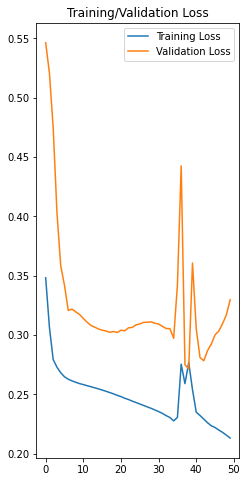

Epoch 1/50
20/20 [==============================] - 0s 13ms/step - loss: 0.3085 - mae: 0.2570 - rmse: 0.2973 - val_loss: 0.2860 - val_mae: 0.2285 - val_rmse: 0.2860
Epoch 2/50
20/20 [==============================] - 0s 10ms/step - loss: 0.3125 - mae: 0.2618 - rmse: 0.3029 - val_loss: 0.2378 - val_mae: 0.1937 - val_rmse: 0.2378
Epoch 3/50
20/20 [==============================] - 0s 11ms/step - loss: 0.2904 - mae: 0.2486 - rmse: 0.2825 - val_loss: 0.3077 - val_mae: 0.2609 - val_rmse: 0.3077
Epoch 4/50
20/20 [==============================] - 0s 10ms/step - loss: 0.2821 - mae: 0.2432 - rmse: 0.2709 - val_loss: 0.2559 - val_mae: 0.2062 - val_rmse: 0.2559
Epoch 5/50
20/20 [==============================] - 0s 10ms/step - loss: 0.2852 - mae: 0.2422 - rmse: 0.2745 - val_loss: 0.2613 - val_mae: 0.2162 - val_rmse: 0.2613

Epoch 00005: val_loss improved from 0.29250 to 0.26132, saving model to my_model_5_0.261.h5
Epoch 6/50
20/20 [==============================] - 0s 12ms/step - loss: 0.2774 - 

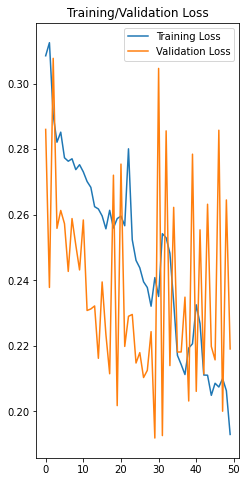

Epoch 1/50
29/29 [==============================] - 0s 13ms/step - loss: 0.2353 - mae: 0.2008 - rmse: 0.2363 - val_loss: 0.5591 - val_mae: 0.4709 - val_rmse: 0.4766
Epoch 2/50
29/29 [==============================] - 0s 11ms/step - loss: 0.2653 - mae: 0.2292 - rmse: 0.2656 - val_loss: 0.3830 - val_mae: 0.3273 - val_rmse: 0.3135
Epoch 3/50
29/29 [==============================] - 0s 11ms/step - loss: 0.2405 - mae: 0.2027 - rmse: 0.2413 - val_loss: 0.4039 - val_mae: 0.3593 - val_rmse: 0.3552
Epoch 4/50
29/29 [==============================] - 0s 10ms/step - loss: 0.2244 - mae: 0.1877 - rmse: 0.2254 - val_loss: 0.3926 - val_mae: 0.3462 - val_rmse: 0.3267
Epoch 5/50
29/29 [==============================] - 0s 11ms/step - loss: 0.2177 - mae: 0.1821 - rmse: 0.2187 - val_loss: 0.4157 - val_mae: 0.3727 - val_rmse: 0.3495

Epoch 00005: val_loss did not improve from 0.19191
Epoch 6/50
29/29 [==============================] - 0s 11ms/step - loss: 0.2105 - mae: 0.1778 - rmse: 0.2116 - val_loss: 0.

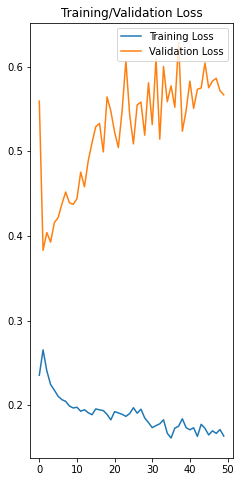

[array([[150.38779, 151.72333, 142.97989, 154.79988]], dtype=float32), array([[176.3053 , 174.7525 , 173.42152, 181.40761]], dtype=float32), array([[294.01456, 293.59784, 287.64276, 296.2062 ]], dtype=float32), array([[305.08127, 303.8385 , 297.91492, 307.295  ]], dtype=float32), array([[258.9119 , 259.48343, 259.48245, 263.68494]], dtype=float32), array([[219.04216, 217.4321 , 216.94682, 221.95859]], dtype=float32), array([[217.99055, 215.83714, 213.401  , 221.4759 ]], dtype=float32), array([[203.24785, 200.74844, 199.48312, 207.28207]], dtype=float32), array([[206.46373, 203.98701, 202.48601, 209.80956]], dtype=float32), array([[297.87003, 296.0429 , 291.89606, 299.95615]], dtype=float32), array([[303.1766 , 301.99762, 300.91376, 304.57004]], dtype=float32), array([[278.42197, 279.65277, 280.60648, 279.54877]], dtype=float32), array([[270.77536, 270.64502, 271.05066, 272.32837]], dtype=float32), array([[206.26361, 204.45346, 202.40392, 209.86351]], dtype=float32), array([[199.17703, 

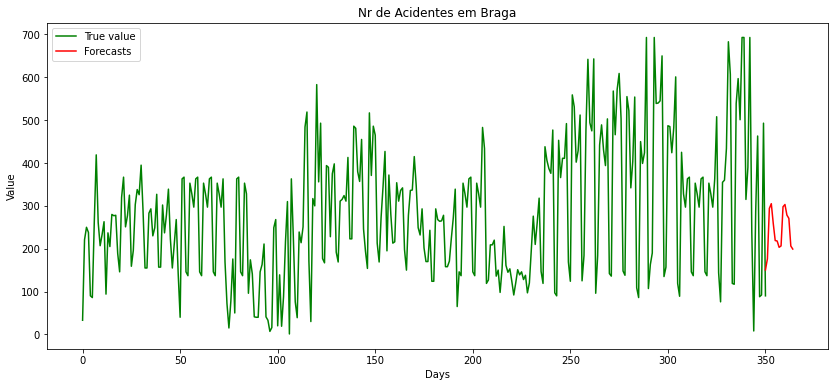

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 260       
Total params: 22,084
Trainable params: 22,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
10/10 [==============================] - 2s 67ms/step - loss: 0.2933 - mae: 0.2419 - rmse: 0.2944 - val_loss: 0.6831 - val_mae: 0.6547 - val_rmse: 0.6831
Epoch 2/90
10/10 [==============================] - 0s 15ms/step - loss: 0.3007 - mae: 0.2537 - rmse: 0.3013 - val_loss: 0.6188 - val_mae: 0.5880 - val_rmse: 0.6188
Epoch 3/90
10/10 [==============================] 

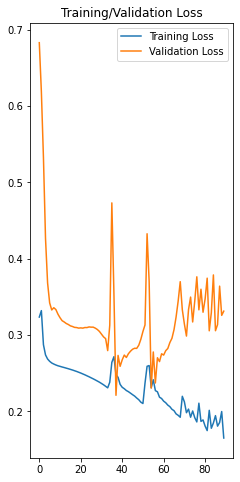

Epoch 1/90
20/20 [==============================] - 0s 14ms/step - loss: 0.3603 - mae: 0.2932 - rmse: 0.3483 - val_loss: 0.3200 - val_mae: 0.2503 - val_rmse: 0.3200
Epoch 2/90
20/20 [==============================] - 0s 11ms/step - loss: 0.3254 - mae: 0.2723 - rmse: 0.3162 - val_loss: 0.2588 - val_mae: 0.2132 - val_rmse: 0.2588
Epoch 3/90
20/20 [==============================] - 0s 11ms/step - loss: 0.2851 - mae: 0.2407 - rmse: 0.2767 - val_loss: 0.2800 - val_mae: 0.2301 - val_rmse: 0.2800
Epoch 4/90
20/20 [==============================] - 0s 11ms/step - loss: 0.2726 - mae: 0.2322 - rmse: 0.2621 - val_loss: 0.2505 - val_mae: 0.2032 - val_rmse: 0.2505
Epoch 5/90
20/20 [==============================] - 0s 12ms/step - loss: 0.2692 - mae: 0.2282 - rmse: 0.2581 - val_loss: 0.2448 - val_mae: 0.1977 - val_rmse: 0.2448

Epoch 00005: val_loss did not improve from 0.23056
Epoch 6/90
20/20 [==============================] - 0s 13ms/step - loss: 0.2673 - mae: 0.2254 - rmse: 0.2580 - val_loss: 0.

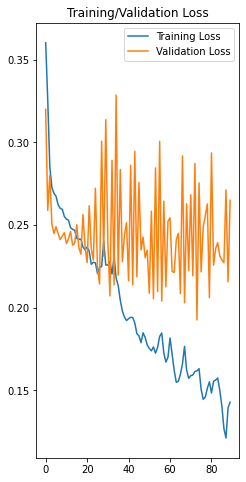

Epoch 1/90
29/29 [==============================] - 0s 13ms/step - loss: 0.2021 - mae: 0.1693 - rmse: 0.2030 - val_loss: 0.4265 - val_mae: 0.3621 - val_rmse: 0.3923
Epoch 2/90
29/29 [==============================] - 0s 10ms/step - loss: 0.2050 - mae: 0.1705 - rmse: 0.2063 - val_loss: 0.4631 - val_mae: 0.4148 - val_rmse: 0.4415
Epoch 3/90
29/29 [==============================] - 0s 11ms/step - loss: 0.2049 - mae: 0.1683 - rmse: 0.2061 - val_loss: 0.4613 - val_mae: 0.4041 - val_rmse: 0.3956
Epoch 4/90
29/29 [==============================] - 0s 10ms/step - loss: 0.1890 - mae: 0.1563 - rmse: 0.1903 - val_loss: 0.5134 - val_mae: 0.4684 - val_rmse: 0.4456
Epoch 5/90
29/29 [==============================] - 0s 11ms/step - loss: 0.1751 - mae: 0.1441 - rmse: 0.1766 - val_loss: 0.4716 - val_mae: 0.4187 - val_rmse: 0.4299

Epoch 00005: val_loss did not improve from 0.20600
Epoch 6/90
29/29 [==============================] - 0s 11ms/step - loss: 0.1704 - mae: 0.1418 - rmse: 0.1720 - val_loss: 0.

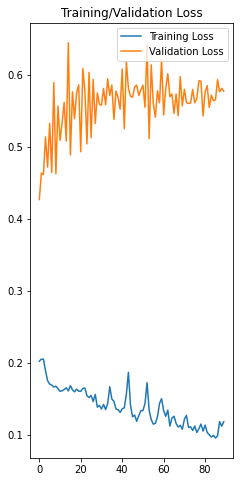

[array([[139.08553, 127.84031, 125.21892, 133.67552]], dtype=float32), array([[168.43918, 160.82492, 162.25087, 160.00026]], dtype=float32), array([[316.19705, 313.43008, 315.48297, 317.68512]], dtype=float32), array([[275.53668, 272.02795, 274.15466, 276.43472]], dtype=float32), array([[259.31992, 251.96735, 248.85497, 254.99323]], dtype=float32), array([[259.99908, 251.47028, 249.12422, 252.71835]], dtype=float32), array([[234.3834 , 229.19785, 229.64067, 230.87091]], dtype=float32), array([[182.33125, 177.01212, 176.52274, 177.69714]], dtype=float32), array([[203.84988, 200.3659 , 199.91289, 200.00372]], dtype=float32), array([[264.51315, 262.7537 , 264.13467, 263.45908]], dtype=float32), array([[264.6434 , 263.01303, 265.39722, 264.6496 ]], dtype=float32), array([[252.08846, 253.94041, 253.1144 , 254.75206]], dtype=float32), array([[273.39542, 273.7481 , 272.1901 , 273.97736]], dtype=float32), array([[223.71039, 221.99583, 222.45105, 222.59758]], dtype=float32), array([[176.77762, 

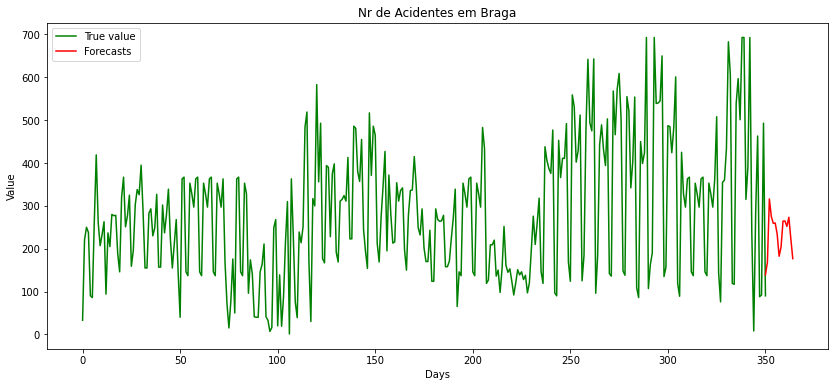

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 260       
Total params: 22,084
Trainable params: 22,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
10/10 [==============================] - 2s 71ms/step - loss: 0.3234 - mae: 0.2684 - rmse: 0.3239 - val_loss: 0.5154 - val_mae: 0.4654 - val_rmse: 0.5154
Epoch 2/120
10/10 [==============================] - 0s 14ms/step - loss: 0.2852 - mae: 0.2453 - rmse: 0.2858 - val_loss: 0.5052 - val_mae: 0.4606 - val_rmse: 0.5052
Epoch 3/120
10/10 [=============================

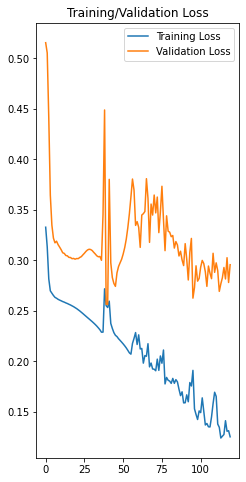

Epoch 1/120
20/20 [==============================] - 0s 14ms/step - loss: 0.3170 - mae: 0.2584 - rmse: 0.3076 - val_loss: 0.3321 - val_mae: 0.2739 - val_rmse: 0.3321
Epoch 2/120
20/20 [==============================] - 0s 12ms/step - loss: 0.2763 - mae: 0.2330 - rmse: 0.2732 - val_loss: 0.3196 - val_mae: 0.2640 - val_rmse: 0.3196
Epoch 3/120
20/20 [==============================] - 0s 10ms/step - loss: 0.2595 - mae: 0.2160 - rmse: 0.2504 - val_loss: 0.2741 - val_mae: 0.2219 - val_rmse: 0.2741
Epoch 4/120
20/20 [==============================] - 0s 11ms/step - loss: 0.2527 - mae: 0.2133 - rmse: 0.2422 - val_loss: 0.2782 - val_mae: 0.2265 - val_rmse: 0.2782
Epoch 5/120
20/20 [==============================] - 0s 10ms/step - loss: 0.2484 - mae: 0.2106 - rmse: 0.2430 - val_loss: 0.2996 - val_mae: 0.2443 - val_rmse: 0.2996

Epoch 00005: val_loss did not improve from 0.25647
Epoch 6/120
20/20 [==============================] - 0s 12ms/step - loss: 0.2428 - mae: 0.2035 - rmse: 0.2331 - val_lo

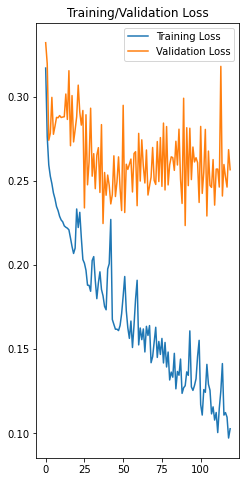

Epoch 1/120
29/29 [==============================] - 0s 13ms/step - loss: 0.2048 - mae: 0.1718 - rmse: 0.2072 - val_loss: 0.4411 - val_mae: 0.3660 - val_rmse: 0.4157
Epoch 2/120
29/29 [==============================] - 0s 11ms/step - loss: 0.2195 - mae: 0.1829 - rmse: 0.2205 - val_loss: 0.4806 - val_mae: 0.4450 - val_rmse: 0.3962
Epoch 3/120
29/29 [==============================] - 0s 10ms/step - loss: 0.1819 - mae: 0.1489 - rmse: 0.1832 - val_loss: 0.4037 - val_mae: 0.3547 - val_rmse: 0.3437
Epoch 4/120
29/29 [==============================] - 0s 11ms/step - loss: 0.1585 - mae: 0.1321 - rmse: 0.1601 - val_loss: 0.4550 - val_mae: 0.4198 - val_rmse: 0.3677
Epoch 5/120
29/29 [==============================] - 0s 10ms/step - loss: 0.1594 - mae: 0.1308 - rmse: 0.1611 - val_loss: 0.4279 - val_mae: 0.3762 - val_rmse: 0.3898

Epoch 00005: val_loss did not improve from 0.22913
Epoch 6/120
29/29 [==============================] - 0s 11ms/step - loss: 0.1535 - mae: 0.1252 - rmse: 0.1548 - val_lo

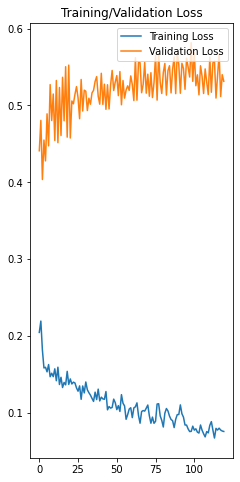

[array([[243.59825, 238.61154, 243.23773, 244.45308]], dtype=float32), array([[287.70145, 280.41864, 285.8754 , 287.61404]], dtype=float32), array([[237.75066, 237.66875, 239.76195, 237.38435]], dtype=float32), array([[278.6588 , 278.06067, 280.0818 , 279.04434]], dtype=float32), array([[260.9032 , 254.88803, 257.39386, 260.341  ]], dtype=float32), array([[221.88402, 219.24144, 220.29294, 221.53934]], dtype=float32), array([[242.63885, 244.82996, 242.91666, 242.30136]], dtype=float32), array([[274.6302 , 275.35443, 274.59247, 274.0898 ]], dtype=float32), array([[281.32587, 280.84378, 281.03436, 280.4103 ]], dtype=float32), array([[231.79532, 235.28716, 235.03079, 231.02135]], dtype=float32), array([[228.78949, 230.61826, 230.53421, 227.26894]], dtype=float32), array([[248.75671, 249.8166 , 249.52184, 246.9751 ]], dtype=float32), array([[228.19691, 229.7039 , 229.4071 , 226.35751]], dtype=float32), array([[218.5575 , 219.79533, 219.5368 , 216.87029]], dtype=float32), array([[255.70987, 

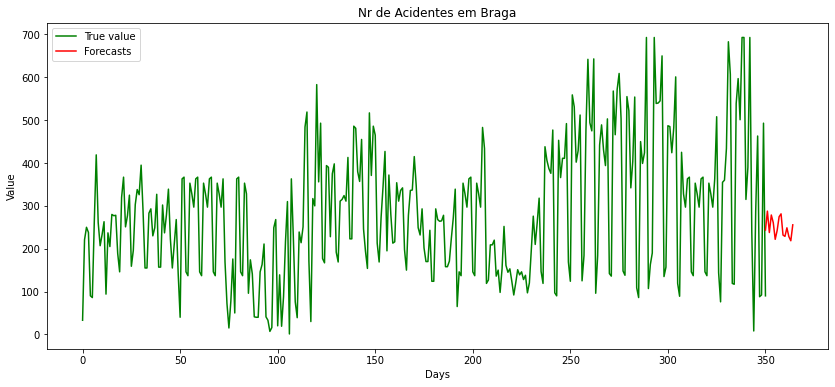

In [17]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [18]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [19]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.2664115682244301, 0.22461353490749994, 0.2675896495580673, 0.30812748819589614, 0.2633999089399974, 0.30243991563717526] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.19911210795243584, 0.1641519344349702, 0.20030480116605762, 0.32237550099690754, 0.2739758479595184, 0.33087872455517453] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.15473689017196499, 0.1272238019357125, 0.15566906730333965, 0.39916931003332135, 0.32952768067518867, 0.4104571408530077] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.19380850079986786, 0.16308336195846398, 0.1946091103884909, 0.3204244611991776, 0.26349679587615865, 0.33193495704068077] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.16388157390885885, 0.13738418607800096, 0.16446840992128406, 0.3248230635016053, 0.2675108920644831, 0.3342825

In [20]:
pd.DataFrame.from_dict(final_dict, orient='index',columns=['Loss', 'MAE', 'RMSE', 'VAL_LOSS', 'VAL_MAE', 'VAL_RMSE'])

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.266412,0.224614,0.267590,0.308127,0.263400,0.302440
2,0.199112,0.164152,0.200305,0.322376,0.273976,0.330879
3,0.154737,0.127224,0.155669,0.399169,0.329528,0.410457
4,0.193809,0.163083,0.194609,0.320424,0.263497,0.331935
5,0.163882,0.137384,0.164468,0.324823,0.267511,0.334283
6,0.135122,0.113486,0.135381,0.360765,0.300785,0.370528
7,0.228577,0.193997,0.227228,0.362874,0.306599,0.350204
8,0.189187,0.158618,0.188547,0.376547,0.316411,0.353523
9,0.162268,0.135730,0.160694,0.367903,0.314284,0.367657
